# TDT05 - SimCLR on CIFAR10

Group members:
- Simen Kristoffersen
- Marius Brogård Lerstein
- Peter Skaar Nordby


## Project setup

### Install necessary packages

In [96]:
%pip install lightning lightly umap-learn

### Import libraries

In [97]:
import numpy as np
import pandas as pd
import umap
import copy
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision.datasets import CIFAR10
import lightning as pl
from tqdm.notebook import tqdm
from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Configuration

In [98]:
PRETRAIN_BATCH_SIZE = 256 # Size of each batch during pretrain
BATCH_SIZE = 32 # Size of each batch
PRETRAIN_EPOCHS = 30 # Number of epochs to pretrain
EPOCHS = 20 # Number of epochs to finetune/train baseline

## Model architectures and function definitions

### Define util functions

In [99]:
def select_subset(dataset: CIFAR100, subset_ratio: float = 0.1):
  n_images = len(dataset)
  idxs = torch.randperm(n_images)[:int(n_images * subset_ratio)]
  return Subset(dataset, idxs)

def evaluate_model(model: nn.Module, dataloader: DataLoader, verbose: bool = True) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  model.to(device)
  model.eval()

  y_predicted, y_true, extracted_features = [], [], []
  losses = []
  with torch.no_grad():
    for (x, y) in tqdm(dataloader):
      x, y = x.to(device), y.to(device)
      y_hat, features = model(x)
      loss = F.cross_entropy(y_hat, y)
      label = torch.argmax(y_hat, dim=1)

      losses.append(loss.item())
      y_predicted.append(label.detach().cpu())
      y_true.append(y.detach().cpu())
      extracted_features.append(features.detach().cpu())

  loss = np.mean(losses)
  if verbose:
    print("Cross-entropy loss:", loss)

  return  torch.cat(y_predicted), torch.cat(y_true), torch.cat(extracted_features), loss

### Define model architectures

In [100]:
"""
SimCLR model from the Lightly-library
"""
class SimCLR(pl.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = SimCLRProjectionHead(512, 512, 128)
        self.criterion = NTXentLoss()
        self.training_step_losses = []

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1) = batch[0]
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.training_step_losses.append(loss.item())
        return loss

    def configure_optimizers(self):
        lr = 0.3*(BATCH_SIZE/256) # recommended learning rate
        optim = SGD(self.parameters(), lr=lr)
        return optim

    def on_train_epoch_end(self) -> None:
        epoch_loss = torch.tensor(self.training_step_losses).float().mean()
        self.log("train_loss", epoch_loss, prog_bar=True)
        self.training_step_losses = []

"""
Finetuned model using pretrain SimCLR backbone for feature extraction
"""
class FinetunedSimCLR(pl.LightningModule):
    def __init__(self, pretrained_model, n_classes: int):
        super().__init__()
        self.backbone = pretrained_model.backbone
        self.classifier = nn.Linear(512, n_classes)
        self.training_step_losses = []

    def training_step(self, batch, batch_index):
        x,y = batch
        y_hat, _ = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.training_step_losses.append(loss.item())
        return loss

    def configure_optimizers(self):
        optim = SGD(self.parameters(), lr=1e-3)
        return optim

    def forward(self, x):
        extracted_features = self.backbone(x).flatten(start_dim=1)
        clf = self.classifier(extracted_features)
        return clf, extracted_features

    def on_train_epoch_end(self) -> None:
        epoch_loss = torch.tensor(self.training_step_losses).float().mean()
        self.log("train_loss", epoch_loss, prog_bar=True)
        self.training_step_losses = []

"""
Baseline CNN model
"""
class CNNClassifier(pl.LightningModule):

    def __init__(self, n_classes: int):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes),
        )
        self.training_step_losses = []

    def forward(self, x):
        extracted_features = self.cnn(x)
        clf = self.classifier(extracted_features)
        return clf, extracted_features

    def training_step(self, batch, batch_index):
        x,y = batch
        y_hat, _ = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.training_step_losses.append(loss.item())
        return loss

    def configure_optimizers(self):
        optim = SGD(self.parameters(), lr=1e-3)
        return optim

    def on_train_epoch_end(self) -> None:
        epoch_loss = torch.tensor(self.training_step_losses).float().mean()
        self.log("train_loss", epoch_loss, prog_bar=True)
        self.training_step_losses = []

## Download dataset and setup dataloaders

In [101]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
# Original train-test split
train_dataset = CIFAR10(root="data", train=True, download=True, transform=transform)
test_dataset = CIFAR10(root="data", train=False, download=True, transform=transform)

input_shape = train_dataset[0][0].shape # Image size
n_classes = len(train_dataset.classes) # Number of classes

# Pretrain on train data using augmentations
pretrain_dataset = CIFAR10(root="data", train=True, download=True, transform=SimCLRTransform(input_size=input_shape[-1]))

"""
Setup dataloaders
"""

# For the experiment, we train on 1%, 5% and 10% on the data
# for both the baseline model and the pretrained model
train_dataset_ratios = [0.01, 0.05, 0.1]
train_dataloaders = []
for ratio in tqdm(train_dataset_ratios, desc="Building train datasets.."):
  dataset_name = f"train-{int(ratio*100)}%"
  subset = select_subset(train_dataset, ratio)
  dataloader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
  train_dataloaders.append((dataset_name, dataloader))

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pretrain_dataloader = DataLoader(pretrain_dataset, batch_size=PRETRAIN_BATCH_SIZE, shuffle=True)

print("Image size:", input_shape)
print("Number of classes:", n_classes)
print("-"*50)
print("Test size:", len(test_dataset), "images")
print("Pretrain size:", len(pretrain_dataset), "images")
for name, dataloader in train_dataloaders:
  print(f" - {name} size:", len(dataloader.dataset), "images")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Building train datasets..:   0%|          | 0/3 [00:00<?, ?it/s]

Image size: torch.Size([3, 32, 32])
Number of classes: 10
--------------------------------------------------
Test size: 10000 images
Pretrain size: 50000 images
 - train-1% size: 500 images
 - train-5% size: 2500 images
 - train-10% size: 5000 images


### Plot images

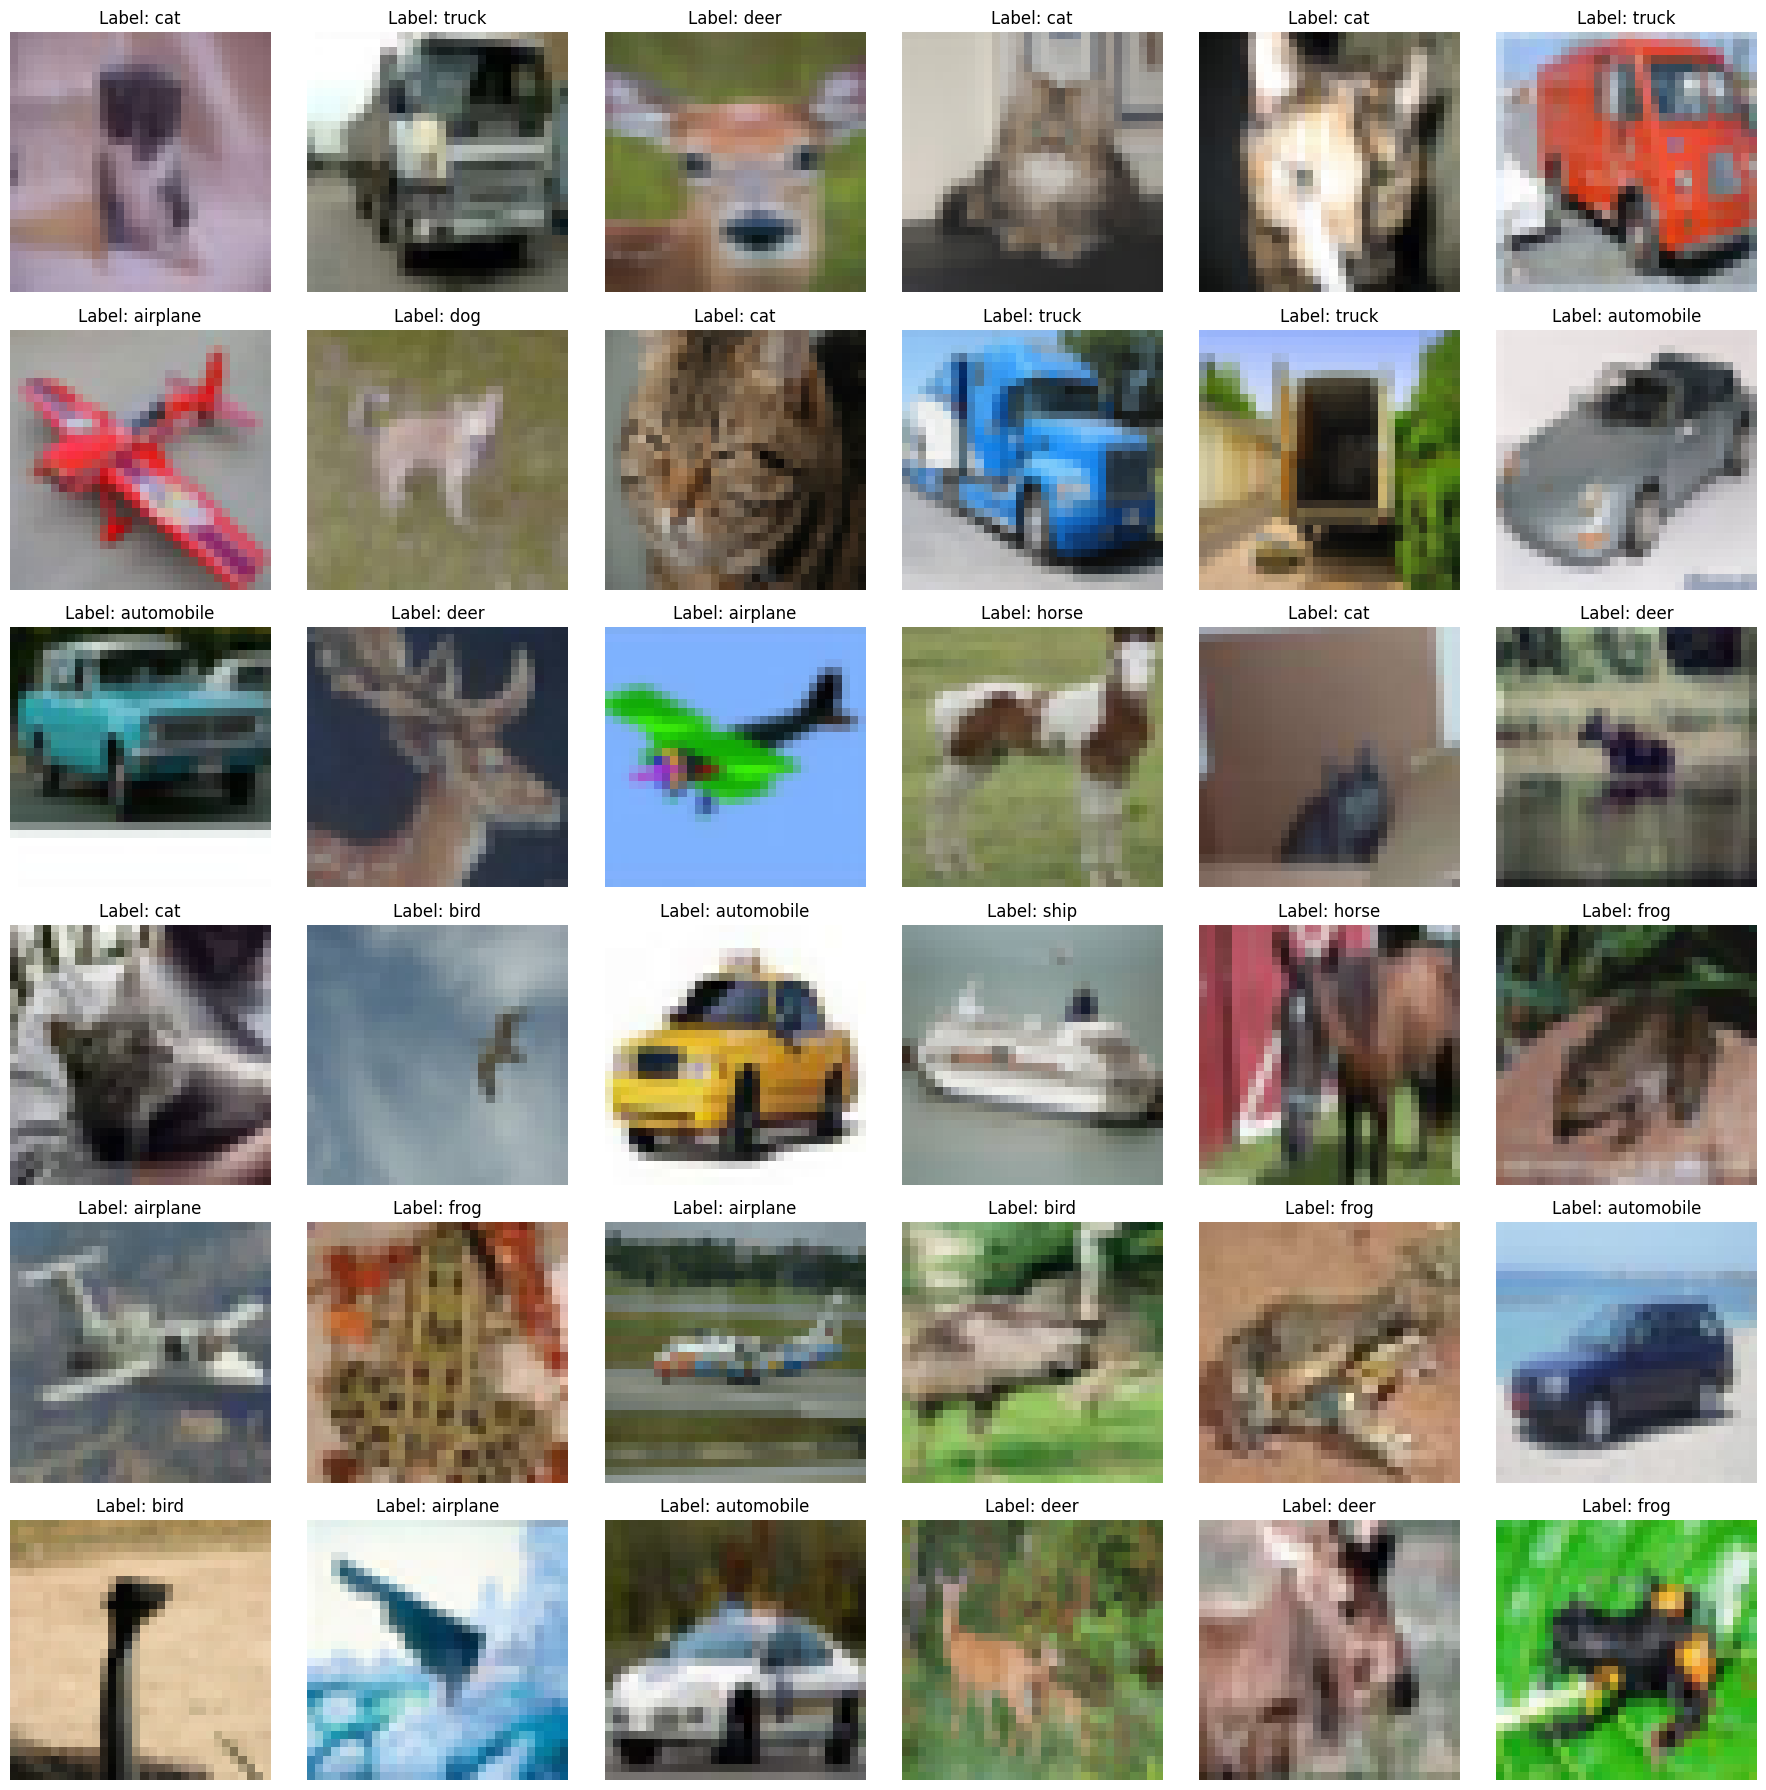

In [122]:
fig, ax = plt.subplots(6, 6, figsize=(18, 18))
ax = ax.flatten()

tmp = CIFAR10(root="data", train=True, download=False)
rand_idxs = torch.randperm(len(tmp))

for i in range(ax.shape[0]):
  idx = rand_idxs[i]
  ax[i].set_title(f"Label: {tmp.classes[tmp[idx][1]]}")
  ax[i].imshow(tmp[idx][0])
  ax[i].axis("off")
fig.tight_layout()

## Model training

### Pretraining the SimCLR model

In [32]:
pretrained_model = SimCLR()

pretrainer = pl.Trainer(max_epochs=PRETRAIN_EPOCHS)
pretrainer.fit(model=pretrained_model, train_dataloaders=pretrain_dataloader)
torch.save(pretrained_model.state_dict(), "pretrained_weights.pkt")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         N

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


### Training the classifiers

Train the classifiers on three datasets consisting of 1%, 5% and 10% of the total training data respectively

In [50]:
trained_models = {}
for name, dataloader in train_dataloaders:
  trained_models[name] = {
      "baseline": None,
      "finetuned": None
  }

  # Train baseline
  baseline_model = CNNClassifier(n_classes=n_classes)
  baseline_trainer = pl.Trainer(max_epochs=EPOCHS)
  baseline_trainer.fit(baseline_model, dataloader)

  # Finetune pretrained model
  backbone = copy.deepcopy(pretrained_model)
  finetuned_model = FinetunedSimCLR(backbone, n_classes=n_classes)
  finetuner = pl.Trainer(max_epochs=EPOCHS)
  finetuner.fit(finetuned_model, dataloader)

  trained_models[name]["baseline"] = baseline_model
  trained_models[name]["finetuned"] = finetuned_model


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type       | Params
------------------------------------------
0 | cnn        | Sequential | 53.7 K
1 | classifier | Sequential | 412 K 
------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.864     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.mo

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type       | Params
------------------------------------------
0 | backbone   | Sequential | 11.2 M
1 | classifier | Linear     | 5.1 K 
------------------------------------------
11.2 M    Trainable 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type       | Params
------------------------------------------
0 | cnn        | Sequential | 53.7 K
1 | classifier | Sequential | 412 K 
------------------------------------------
466 K     Trainable 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type       | Params
------------------------------------------
0 | backbone   | Sequential | 11.2 M
1 | classifier | Linear     | 5.1 K 
------------------------------------------
11.2 M    Trainable 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type       | Params
------------------------------------------
0 | cnn        | Sequential | 53.7 K
1 | classifier | Sequential | 412 K 
------------------------------------------
466 K     Trainable 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type       | Params
------------------------------------------
0 | backbone   | Sequential | 11.2 M
1 | classifier | Linear     | 5.1 K 
------------------------------------------
11.2 M    Trainable 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## Evaluate models

### Latent space representation

  0%|          | 0/313 [00:00<?, ?it/s]

<Axes: >

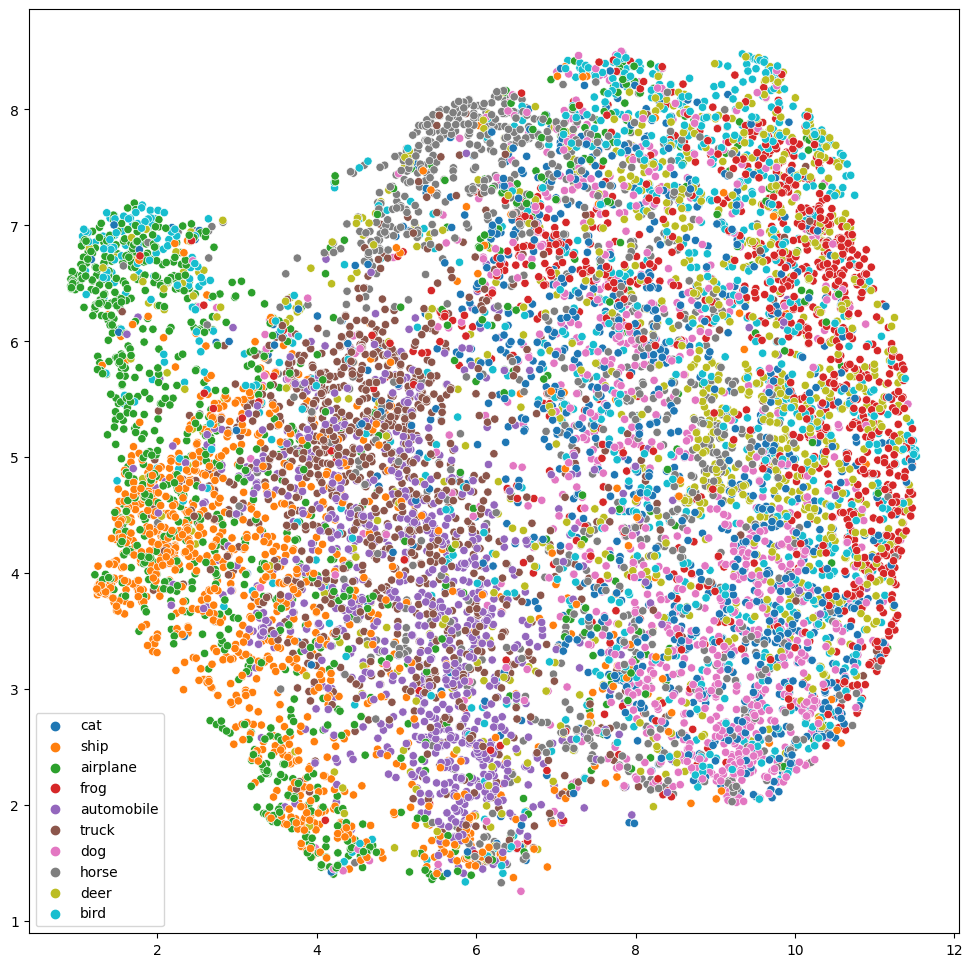

In [95]:
fig, ax = plt.subplots(1,1,figsize=(12, 12))
tmp_model = trained_models["train-10%"]["finetuned"]
_, labels, representations, _ = evaluate_model(tmp_model, test_dataloader, verbose=False)
hue = [train_dataset.classes[label] for label in labels]

# Map representations to a 2d-space
mapper = umap.UMAP(random_state=42)
manifold = mapper.fit_transform(representations.numpy())

sns.scatterplot(x=manifold[:, 0], y=manifold[:, 1], hue=hue, ax=ax)

### Results on test dataset

In [80]:
results = []

#### Training on 1% of the data

In [81]:
baseline, finetuned = trained_models["train-1%"]["baseline"], trained_models["train-1%"]["finetuned"]

# Baseline
y_pred, y_true, _, loss = evaluate_model(baseline, test_dataloader)
accuracy = accuracy_score(y_pred, y_true)
results.append(["train-1%", "baseline", accuracy, loss])
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# Finetuned
y_pred, y_true, _, loss = evaluate_model(finetuned, test_dataloader)
accuracy = accuracy_score(y_pred, y_true)
results.append(["train-1%", "ssl", accuracy, loss])
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

  0%|          | 0/313 [00:00<?, ?it/s]

Cross-entropy loss: 4.28345826715707
              precision    recall  f1-score   support

    airplane       0.42      0.46      0.44      1000
  automobile       0.47      0.40      0.43      1000
        bird       0.25      0.31      0.28      1000
         cat       0.22      0.22      0.22      1000
        deer       0.24      0.21      0.22      1000
         dog       0.30      0.35      0.33      1000
        frog       0.39      0.48      0.43      1000
       horse       0.39      0.36      0.38      1000
        ship       0.41      0.40      0.40      1000
       truck       0.40      0.26      0.32      1000

    accuracy                           0.35     10000
   macro avg       0.35      0.35      0.34     10000
weighted avg       0.35      0.35      0.34     10000



  0%|          | 0/313 [00:00<?, ?it/s]

Cross-entropy loss: 1.6837819715658315
              precision    recall  f1-score   support

    airplane       0.50      0.47      0.48      1000
  automobile       0.43      0.44      0.43      1000
        bird       0.29      0.23      0.26      1000
         cat       0.21      0.10      0.13      1000
        deer       0.40      0.07      0.12      1000
         dog       0.33      0.47      0.38      1000
        frog       0.34      0.64      0.44      1000
       horse       0.40      0.47      0.43      1000
        ship       0.49      0.51      0.50      1000
       truck       0.44      0.48      0.46      1000

    accuracy                           0.39     10000
   macro avg       0.38      0.39      0.36     10000
weighted avg       0.38      0.39      0.36     10000



#### Training on 5% of the data

In [82]:
baseline, finetuned = trained_models["train-5%"]["baseline"], trained_models["train-5%"]["finetuned"]

# Baseline
y_pred, y_true, _, loss = evaluate_model(baseline, test_dataloader)
accuracy = accuracy_score(y_pred, y_true)
results.append(["train-5%", "baseline", accuracy, loss])
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# Finetuned
y_pred, y_true, _, loss = evaluate_model(finetuned, test_dataloader)
accuracy = accuracy_score(y_pred, y_true)
results.append(["train-5%", "ssl", accuracy, loss])
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

  0%|          | 0/313 [00:00<?, ?it/s]

Cross-entropy loss: 3.84256567437047
              precision    recall  f1-score   support

    airplane       0.52      0.56      0.54      1000
  automobile       0.64      0.52      0.57      1000
        bird       0.33      0.36      0.35      1000
         cat       0.34      0.32      0.33      1000
        deer       0.42      0.35      0.38      1000
         dog       0.40      0.45      0.42      1000
        frog       0.56      0.61      0.59      1000
       horse       0.56      0.54      0.55      1000
        ship       0.57      0.65      0.61      1000
       truck       0.54      0.50      0.52      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



  0%|          | 0/313 [00:00<?, ?it/s]

Cross-entropy loss: 1.4850604975947177
              precision    recall  f1-score   support

    airplane       0.55      0.51      0.53      1000
  automobile       0.51      0.59      0.55      1000
        bird       0.34      0.37      0.35      1000
         cat       0.28      0.26      0.27      1000
        deer       0.49      0.26      0.34      1000
         dog       0.39      0.42      0.41      1000
        frog       0.51      0.60      0.55      1000
       horse       0.46      0.59      0.51      1000
        ship       0.65      0.52      0.58      1000
       truck       0.50      0.52      0.51      1000

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.46     10000
weighted avg       0.47      0.46      0.46     10000



#### Training on 10% of the data

In [83]:
baseline, finetuned = trained_models["train-10%"]["baseline"], trained_models["train-10%"]["finetuned"]

# Baseline
y_pred, y_true, _, loss = evaluate_model(baseline, test_dataloader)
accuracy = accuracy_score(y_pred, y_true)
results.append(["train-10%", "baseline", accuracy, loss])
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# Finetuned
y_pred, y_true, _, loss = evaluate_model(finetuned, test_dataloader)
accuracy = accuracy_score(y_pred, y_true)
results.append(["train-10%", "ssl", accuracy, loss])
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

  0%|          | 0/313 [00:00<?, ?it/s]

Cross-entropy loss: 3.5242018002671553
              precision    recall  f1-score   support

    airplane       0.48      0.67      0.56      1000
  automobile       0.64      0.45      0.53      1000
        bird       0.38      0.32      0.35      1000
         cat       0.35      0.25      0.30      1000
        deer       0.41      0.41      0.41      1000
         dog       0.44      0.40      0.42      1000
        frog       0.56      0.53      0.54      1000
       horse       0.57      0.59      0.58      1000
        ship       0.57      0.66      0.61      1000
       truck       0.46      0.60      0.52      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.49      0.49      0.48     10000



  0%|          | 0/313 [00:00<?, ?it/s]

Cross-entropy loss: 1.3690013950244306
              precision    recall  f1-score   support

    airplane       0.55      0.61      0.58      1000
  automobile       0.60      0.56      0.58      1000
        bird       0.44      0.29      0.35      1000
         cat       0.37      0.31      0.33      1000
        deer       0.48      0.37      0.42      1000
         dog       0.39      0.54      0.45      1000
        frog       0.57      0.62      0.59      1000
       horse       0.58      0.58      0.58      1000
        ship       0.67      0.62      0.64      1000
       truck       0.50      0.64      0.56      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



### Plotting the results

In [84]:
results_df = pd.DataFrame(results, columns=["% of data", "model", "accuracy", "cross-entropy loss"])
results_df

,% of data,model,accuracy,cross-entropy loss
0,train-1%,baseline,0.3458,4.283458
1,train-1%,ssl,0.3867,1.683782
2,train-5%,baseline,0.4859,3.842566
3,train-5%,ssl,0.4640,1.485060
4,train-10%,baseline,0.4876,3.524202
5,train-10%,ssl,0.5131,1.369001


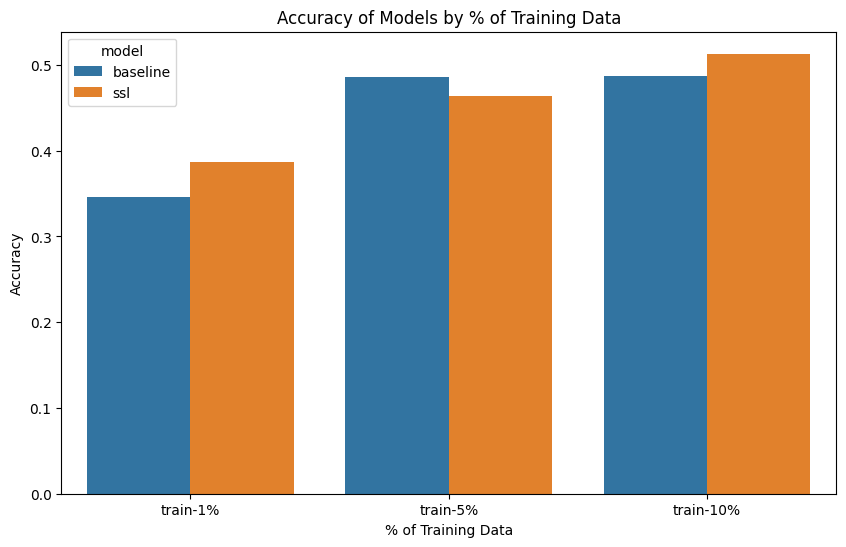

In [85]:
plt.figure(figsize=(10, 6))
sns.barplot(x='% of data', y='accuracy', hue='model', data=results_df)
plt.title('Accuracy of Models by % of Training Data')
plt.xlabel('% of Training Data')
plt.ylabel('Accuracy')
plt.show()

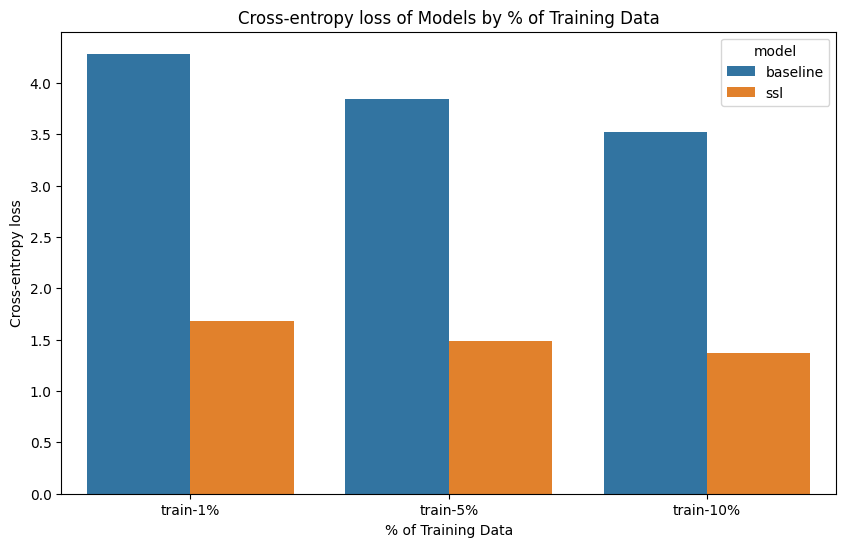

In [86]:
plt.figure(figsize=(10, 6))
sns.barplot(x='% of data', y='cross-entropy loss', hue='model', data=results_df)
plt.title('Cross-entropy loss of Models by % of Training Data')
plt.xlabel('% of Training Data')
plt.ylabel('Cross-entropy loss')
plt.show()